### TEAM ZM5

# EDSA MOVIE RECOMMENDATION CHALLENGE 

### Installing packages
Please download all relevant packages in. There is no terminal so you will need to pip install everything.

In [ ]:
# 20:27

In [1]:
#!wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/27685/2229266/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626119890&Signature=RvOBNnir2bFl4hFPSH%2BHXmXKo75wdgbykpMl2SAWO%2FvM3uvSpT60IxVyI5dFDpBzi%2FKs0ljnJ59nOlHwqMe6zrFEj%2F1v3rS0oZJAn5iJFnO9QnwFMnhpf9IQJFUFHitvZ%2F9VF8zD7vMnK1QioodteZUxYc458hfBSHtZaBXq9KaurVFJf8c21KMm%2FxKz9KOKyLKx8nTDogkIUdK%2FQ852tUQrUTaUxS376BENKmzBhtukOiizqESj3ihlJ%2BFNsMPWGetf0IFm0x8GTWO5lfH5mcOHKi43sirvrCe2tR1ANbgVh34uwo7N9B9jec%2FOa%2F8iAR%2F4IiDCzJsU3tv1ydBVJA%3D%3D&response-content-disposition=attachment%3B+filename%3Dedsa-movie-recommendation-challenge.zip"

In [2]:
#!unzip '/content/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626119890&Signature=RvOBNnir2bFl4hFPSH+HXmXKo75wdgbykpMl2SAWO%2FvM3uvSpT60IxVyI5dFDpBzi%2FKs0ljnJ59nOlHwqMe6zrFEj%2F1v3rS0oZJAn5iJFnO9QnwFMnhpf9IQJFUFHit'

In [3]:
!pip install LibRecommender
!pip install surprise
!pip install comet_ml

### Imports

In [4]:
import comet_ml

In [5]:
# First import comet_ml at the top of your file
from comet_ml import Experiment

In [6]:
# Create an experiment with your api key for version control
experiment = Experiment(
    api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
    project_name="movie-reccomender-edsa",
    workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/movie-reccomender-edsa/fdf5400f0db94c3ab3d0bb7342d892e9



In [7]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

from libreco.data import random_split, DatasetPure, DataInfo
from libreco.data import split_by_ratio_chrono, DatasetFeat
from libreco.algorithms import SVD as libSVD
from libreco.algorithms import SVDpp
from libreco.algorithms import FM, WideDeep, DeepFM, AutoInt, DIN
from libreco.evaluation import evaluate
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time
from time import sleep
import gc

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

### Reading in data

In [8]:
root_path = '../input/recomdata/'
df_sample_submission = pd.read_csv(root_path + 'sample_submission.csv')
df_movies = pd.read_csv(root_path + 'movies.csv')
df_imdb = pd.read_csv(root_path + 'imdb_data.csv')
df_genome_scores = pd.read_csv(root_path + 'genome_scores.csv')
df_genome_tags = pd.read_csv(root_path +'genome_tags.csv')
train = pd.read_csv(root_path + 'train.csv')
df_test = pd.read_csv(root_path + 'test.csv')
df_tags = pd.read_csv(root_path + 'tags.csv')
df_links = pd.read_csv(root_path + 'links.csv')

In [9]:
#df_genres = pd.read_csv(root_path + 'genres.csv')

In [10]:
pd.set_option("display.max.column", None)
print(df_sample_submission.info())
df_sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   rating  float64
dtypes: float64(1), object(1)
memory usage: 76.3+ MB
None


,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [11]:
print(df_movies.info())
df_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
print(df_imdb.info())
df_imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [13]:
print(df_genome_scores.info())
df_genome_scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [14]:
print(df_genome_tags.info())
df_genome_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [15]:
print(df_tags.info())
df_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
None


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [16]:
print(df_links.info())
df_links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [17]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [18]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB
None


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


# Exploratory Data Analysis

**Most common Genres**

In [19]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


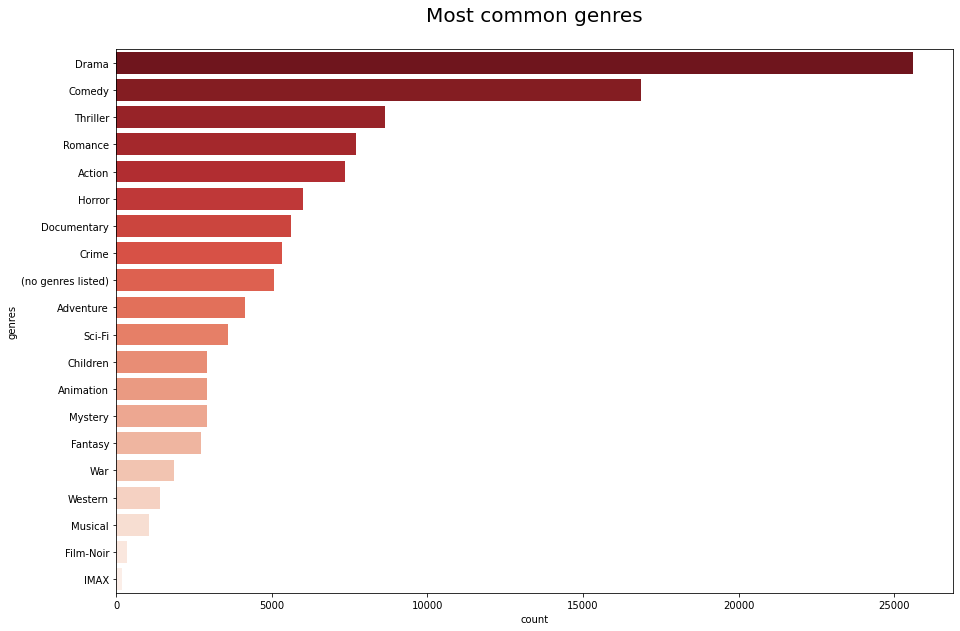

In [20]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Most common actors**

In [21]:
# Create dataframe containing only the movieId and cast members
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie - cast member combination is in a seperate row
cast = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

mostc_cast = cast['title_cast'].value_counts(ascending=False).index.tolist()[:50]

print('Total Cast Members:', len(list(cast['title_cast'].unique())))
print('Most Common Cast Members:\n', mostc_cast)
display(cast.head())

Total Cast Members: 121036
Most Common Cast Members:
 ['nan', 'Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Christopher Walken', 'Brian Cox', 'Gérard Depardieu', 'Morgan Freeman', 'Bruce Willis', 'Danny Glover', 'Nicolas Cage', 'Alec Baldwin', 'Peter Stormare', 'Susan Sarandon', 'Stanley Tucci', 'Julianne Moore', 'Richard Jenkins', 'John Goodman', 'Tom Wilkinson', 'Stellan Skarsgård', 'Woody Harrelson', 'Val Kilmer', 'Christopher McDonald', 'Antonio Banderas', 'Jeff Bennett', 'Johnny Depp', 'Ed Harris', 'Harvey Keitel', 'Forest Whitaker', 'John Leguizamo', 'Donald Sutherland', 'John Cusack', 'Ray Liotta', 'Luis Guzmán', 'Stephen Tobolowsky', 'Paul Giamatti', 'Jim Broadbent', 'Danny Trejo', 'George W. Bush', 'Ewan McGregor', 'John Malkovich', 'Richard Riehle', 'David Strathairn', 'Kathy Bates', 'Robert Downey Jr.', 'Ving Rhames', 'Jim Cummings', 'Patricia Clarkson']


,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


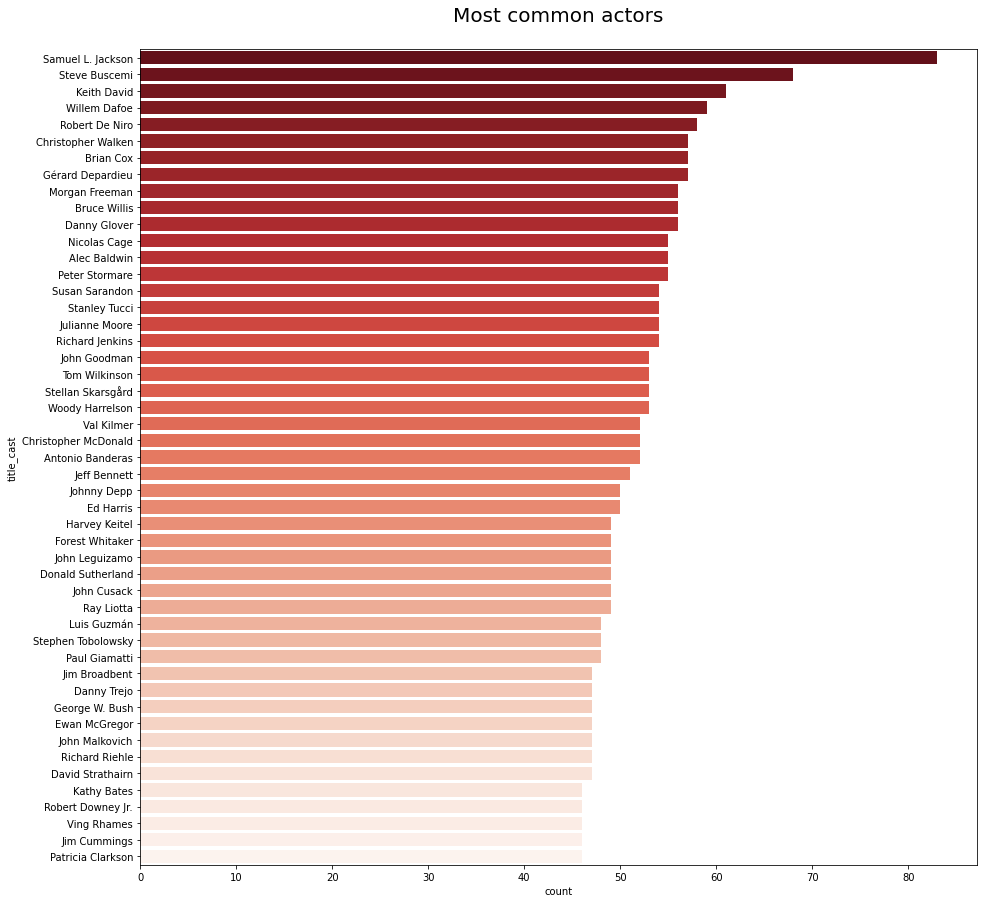

In [22]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 15))
plt.title('Most common actors\n', fontsize=20)
sns.countplot(y="title_cast", data=cast,
              order=mostc_cast[1:50],
              palette='Reds_r')
plt.show()

## Data Prepartion

In [23]:
df_train = train.copy()

rating_count = df_train.groupby('movieId')['rating'].count().reset_index()
rating_count.rename(columns = {'rating': 'movie_rating_count'}, inplace=True)
df_train = df_train.merge(rating_count, on='movieId')

user_count = df_train.groupby('userId')['rating'].count().reset_index()
user_count.rename(columns={'rating': 'user_rating_count'}, inplace=True)
df_train=df_train.merge(user_count, on='userId')

df_train = df_train[df_train['movie_rating_count'] > 20]
df_train = df_train[df_train['user_rating_count'] > 5]
display(df_train.head(3))
df_train.drop(['movie_rating_count','user_rating_count'], 1, inplace=True)
print(df_train.shape)
display(df_train.head(3))

,userId,movieId,rating,timestamp,movie_rating_count,user_rating_count
0,5163,57669,4.0,1518349992,4253,22
1,5163,2671,1.0,1545511636,5698,22
2,5163,1247,4.5,1434310106,7569,22


(9848791, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,5163,2671,1.0,1545511636
2,5163,1247,4.5,1434310106


In [24]:
def create_features(df, column, features):
    """Creates features from a column of lists where the list items will be the features."""
    
    features_df = pd.DataFrame(columns = features)
    all_features = pd.concat([df, features_df], axis=1)

    for i,row in all_features.iterrows():
        for feature in features:
            if feature in getattr(row,column):
                all_features[feature].iloc[i]= 1
    all_features = all_features.drop(column, axis=1)
    
    return all_features

In [25]:
df_imdb.fillna(0, inplace=True)
df_imdb.budget = df_imdb.budget.astype(str).apply(lambda x: int(re.sub("[^0-9]", "", x)))

In [26]:
%%time
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))
genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)']

genre_encode = create_features(movies_genres, 'genres', genres)
genre_encode.head(4)

CPU times: user 1min 57s, sys: 2.74 s, total: 2min
Wall time: 1min 55s


,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
%%time
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))
cast_movie = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])
mostc_cast = cast_movie['title_cast'].value_counts(ascending=False).index.tolist()[:16]

cast_encode = create_features(cast, 'title_cast', mostc_cast[1:])
cast_encode.head(4)

CPU times: user 510 ms, sys: 12.8 ms, total: 523 ms
Wall time: 519 ms


,movieId,Samuel L. Jackson,Steve Buscemi,Keith David,Willem Dafoe,Robert De Niro,Christopher Walken,Gérard Depardieu,Brian Cox,Danny Glover,Bruce Willis,Morgan Freeman,Alec Baldwin,Nicolas Cage,Peter Stormare,Richard Jenkins
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
gc.collect()
del rating_count, user_count, movies_genres, cast, cast_movie
sleep(10)

## Modelling 



### Collaborative Filtering 

In [29]:
%%time
ratings = df_train.copy()
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

CPU times: user 28.4 s, sys: 4.99 s, total: 33.4 s
Wall time: 33.3 s


In [30]:
%%time
trainset, testset = train_test_split(data, test_size=.01, random_state = 1)

CPU times: user 43.1 s, sys: 3.66 s, total: 46.7 s
Wall time: 46.6 s


In [31]:
gc.collect()
del ratings, ratings_dict, df, data
sleep(10)

#### SVD      (surprise Package)

In [32]:
%%time
algo = SVD(n_epochs= 1)
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.9059
MAE:  0.6940
CPU times: user 1min 3s, sys: 154 ms, total: 1min 3s
Wall time: 1min 3s


0.6940189882031744

In [33]:
gc.collect()
del algo
sleep(10)

In [34]:
%%time
algo = SVD(random_state = 1, n_epochs= 1, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, 
           init_std_dev = 0.005, init_mean = -0.037)
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions) # rmse: 0.8101      5min 29s
accuracy.mae(predictions)

Processing epoch 0
RMSE: 0.8869
MAE:  0.6799
CPU times: user 1min 44s, sys: 154 ms, total: 1min 44s
Wall time: 1min 44s


0.6799301078959076

In [36]:
gc.collect()
del algo, trainset, testset, 
sleep(10)

In [37]:
#trainset = data.build_full_trainset()
#algo = SVD(random_state = 1, n_epochs= 16, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, init_std_dev = 0.005, init_mean = -0.037)
#algo.fit(trainset)

#### SVD (LibRecommender package)

In [38]:
%%time
data = df_train.copy()
data.rename(columns={'userId':'user'},inplace=True)
data.rename(columns={'movieId':'item'},inplace=True)
data.rename(columns={'rating':'label'},inplace=True)
data.rename(columns={'timestamp':'time'},inplace=True)

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 160834, n_items: 13036, data sparsity: 0.4650 %
CPU times: user 33.6 s, sys: 1.42 s, total: 35 s
Wall time: 35 s


In [39]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

In [40]:
%%time
reset_state('libSVD')
svd_lib = libSVD(task="rating", data_info=data_info, embed_size=16, n_epochs=3, lr=0.005,batch_size=10000, 
                 batch_sampling=True)  # embed_size=8, n_epochs=3, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svd_lib.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svd_lib, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== libSVD ==============================
Training start time: 2021-07-12 18:40:06


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 319.86it/s]


Epoch 1 elapsed: 21.805s
	 train_loss: 0.7869
	 eval rmse: 0.8299
	 eval mae: 0.6307
	 eval r2: 0.3868


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 366.60it/s]


Epoch 2 elapsed: 21.338s
	 train_loss: 0.6191
	 eval rmse: 0.8163
	 eval mae: 0.6198
	 eval r2: 0.4068


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 375.50it/s]


Epoch 3 elapsed: 21.399s
	 train_loss: 0.5485
	 eval rmse: 0.8184
	 eval mae: 0.6206
	 eval r2: 0.4037


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 368.38it/s]

evaluate_result:  {'rmse': 0.8182875956948238, 'mae': 0.619840243465284}
CPU times: user 2min 36s, sys: 6.14 s, total: 2min 42s
Wall time: 1min 5s


In [41]:
print("prediction: ", svd_lib.predict(user=5163, item=57669))
print("recommendation: ", svd_lib.recommend_user(user=5163, n_rec=5))
svd_lib.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.3803043]
recommendation:  [(127098, 5.3570924), (134252, 5.116812), (89554, 5.0790653), (134796, 5.07345), (99764, 5.0712185)]


array([4.3803043, 2.821956 , 4.1678967, 4.3420568, 3.3537343, 4.393106 ,
       4.2696743, 4.188861 , 4.5113606, 4.635789 ], dtype=float32)

In [42]:
gc.collect()
del data, svd_lib
sleep(10)

SVDpp from Librecommender

In [43]:
%%time
reset_state('SVDpp')
svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.005,batch_size=100000,
              batch_sampling=True)  # embed_size=16, n_epochs=2, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svdpp.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svdpp, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== SVDpp ==============================
Training start time: 2021-07-12 18:41:22


train: 100%|██████████| 98/98 [02:08<00:00,  1.31s/it]


Epoch 1 elapsed: 135.496s
	 train_loss: 0.8607


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 333.76it/s]


	 eval rmse: 0.8711
	 eval mae: 0.6690
	 eval r2: 0.3244


train: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]


Epoch 2 elapsed: 109.201s
	 train_loss: 0.7007


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 403.50it/s]


	 eval rmse: 0.8291
	 eval mae: 0.6332
	 eval r2: 0.3880


eval_pred: 100%|██████████| 7/7 [00:00<00:00, 409.59it/s]

evaluate_result:  {'rmse': 0.8270241662181768, 'mae': 0.6303076024863443}
CPU times: user 5min 19s, sys: 1min 21s, total: 6min 40s
Wall time: 4min 29s


In [44]:
print("prediction: ", svdpp.predict(user=5163, item=57669))
print("recommendation: ", svdpp.recommend_user(user=5163, n_rec=5))
svdpp.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.138764]
recommendation:  [(296, 4.594305), (2959, 4.5410466), (1196, 4.5067353), (318, 4.4755526), (593, 4.407298)]


array([4.138764 , 3.3310084, 3.9563677, 4.496218 , 3.6434343, 4.141286 ,
       4.0145783, 3.3672855, 3.9786308, 4.2882805], dtype=float32)

In [45]:
gc.collect()
del svdpp, train_data, data_info, eval_data, test_data
sleep(10)

Train SVDpp on full dataset

In [46]:
# data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
# train_data, data_info = DatasetPure.build_trainset(data)

# reset_state('SVDpp')
# svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.005,batch_size=10000, batch_sampling=True)
# svdpp.fit(train_data, verbose=2)

Save SVDpp model

In [47]:
"""
data_info.save(path="SVDpp_model_path")
svdpp.save(path="SVDpp_model_path", model_name="svdpp_model", manual=True,
                inference_only=False)
"""

'\ndata_info.save(path="SVDpp_model_path")\nsvdpp.save(path="SVDpp_model_path", model_name="svdpp_model", manual=True,\n                inference_only=False)\n'

In [48]:
"""
tf.compat.v1.reset_default_graph()
data_info = DataInfo.load("SVDpp_model_path")

svdpp_loaded = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, 
                                                lr=0.005,batch_size=10000, batch_sampling=True)

data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])
train_data, data_info = DatasetPure.build_trainset(train_data)
svdpp_loaded.rebuild_graph(path="SVDpp_model_path", model_name="svdpp_model",
                        full_assign=True, train_data=train_data)
"""

'\ntf.compat.v1.reset_default_graph()\ndata_info = DataInfo.load("SVDpp_model_path")\n\nsvdpp_loaded = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, \n                                                lr=0.005,batch_size=10000, batch_sampling=True)\n\ndata = pd.read_csv(root_path + \'train.csv\', header=0, names = ["user", "item", "label", "time"])\ntrain_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])\ntrain_data, data_info = DatasetPure.build_trainset(train_data)\nsvdpp_loaded.rebuild_graph(path="SVDpp_model_path", model_name="svdpp_model",\n                        full_assign=True, train_data=train_data)\n'

In [49]:
#svdpp_loaded.predict(df_train['userId'][:10], df_train['movieId'][:10])

### Hybrid Models

In [50]:
%%time
mergeded_train = df_train.copy()
mergeded_train = pd.merge(df_train, genre_encode,on= 'movieId', how='left')
mergeded_train = pd.merge(df_train, cast_encode, on= 'movieId', how='left')
print(df_train.shape)

(9848791, 4)
CPU times: user 5.07 s, sys: 4.65 s, total: 9.71 s
Wall time: 9.65 s


In [51]:
gc.collect()
del genre_encode, cast_encode
sleep(10)

In [52]:
%%time
mergeded_train = pd.merge(mergeded_train, df_imdb[['movieId','director', 'runtime', 
                                                   'budget']], on= 'movieId').fillna(0)
mergeded_train.head()

CPU times: user 1min 9s, sys: 8.6 s, total: 1min 18s
Wall time: 1min 17s


,userId,movieId,rating,timestamp,Samuel L. Jackson,Steve Buscemi,Keith David,Willem Dafoe,Robert De Niro,Christopher Walken,Gérard Depardieu,Brian Cox,Danny Glover,Bruce Willis,Morgan Freeman,Alec Baldwin,Nicolas Cage,Peter Stormare,Richard Jenkins,director,runtime,budget
0,5163,57669,4.0,1518349992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Martin McDonagh,107.0,15000000
1,87388,57669,3.5,1237455297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Martin McDonagh,107.0,15000000
2,137050,57669,4.0,1425631854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Martin McDonagh,107.0,15000000
3,120490,57669,4.5,1408228517,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Martin McDonagh,107.0,15000000
4,50616,57669,4.5,1446941640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Martin McDonagh,107.0,15000000


In [53]:
columns = list(mergeded_train.columns)
print(columns[4:])

['Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Christopher Walken', 'Gérard Depardieu', 'Brian Cox', 'Danny Glover', 'Bruce Willis', 'Morgan Freeman', 'Alec Baldwin', 'Nicolas Cage', 'Peter Stormare', 'Richard Jenkins', 'director', 'runtime', 'budget']


In [54]:
mergeded_train.to_csv('train_feat.csv', index=False)

In [55]:
from IPython.display import FileLink
FileLink('./train_feat.csv')

/kaggle/working/train_feat.csv

In [57]:
%%time
#df_train = pd.read_csv('./train_feat.csv')
mergeded_train.rename(columns={'userId':'user', 'movieId':'item','rating':'label', 
                               'timestamp':'time'}, inplace=True)

columns = list(mergeded_train.columns)
sparse_col = columns[4:]
item_col = columns[4:]

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(
    mergeded_train, multi_ratios=[0.99, 0.005, 0.005])

train_data, data_info = DatasetFeat.build_trainset(train_data, item_col,
                                                   sparse_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)
print(data_info)

n_users: 160815, n_items: 11637, data sparsity: 0.5052 %
CPU times: user 44.9 s, sys: 3.66 s, total: 48.6 s
Wall time: 48.4 s


In [58]:
gc.collect()
del mergeded_train, columns, sparse_col, item_col
sleep(10)

In [59]:
%%time
reset_state("FM")
fm = FM("rating", data_info, embed_size=16, n_epochs=2,
            lr=0.001, lr_decay=False, reg=None, batch_size=100000,
            num_neg=1, use_bn=True, dropout_rate=0.5, tf_sess_config=None)
fm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=fm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== FM ==============================
Training start time: 2021-07-12 18:52:23
total params: 2,931,770 | embedding params: 2,931,720 | network params: 50


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 96.78it/s]


Epoch 1 elapsed: 14.368s
	 train_loss: 10.4823
	 eval rmse: 2.6867
	 eval mae: 2.4892
	 eval r2: -5.4552


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 203.95it/s]


Epoch 2 elapsed: 13.895s
	 train_loss: 4.3877
	 eval rmse: 1.5659
	 eval mae: 1.3751
	 eval r2: -1.1929


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 182.68it/s]

evaluate_result:  {'rmse': 1.5686705071556195, 'mae': 1.3789480666054885}
CPU times: user 55.7 s, sys: 2.36 s, total: 58 s
Wall time: 29.7 s


In [60]:
gc.collect()
del fm
sleep(10)

In [61]:
%%time
reset_state("Wide_Deep")
wd = WideDeep("rating", data_info, embed_size=16, n_epochs=2,
              lr={"wide": 0.01, "deep": 1e-4}, lr_decay=False, reg=None,
              batch_size=100000, num_neg=1, use_bn=False, dropout_rate=None,
              hidden_units="128,64,32", tf_sess_config=None)
wd.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
       metrics=["rmse", "mae", "r2"])
# do final evaluation on test data
print("evaluate_result: ", evaluate(model=wd, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== Wide_Deep ==============================
Training start time: 2021-07-12 18:53:03
total params: 2,946,314 | embedding params: 2,931,944 | network params: 14,370


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 69.27it/s]


Epoch 1 elapsed: 32.017s
	 train_loss: 10.4797
	 eval rmse: 2.5055
	 eval mae: 2.3076
	 eval r2: -4.6139


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 90.24it/s]


Epoch 2 elapsed: 31.717s
	 train_loss: 2.6442
	 eval rmse: 1.0188
	 eval mae: 0.8166
	 eval r2: 0.0718


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 91.52it/s]

evaluate_result:  {'rmse': 1.0184181549901004, 'mae': 0.8163813539832403}
CPU times: user 2min 47s, sys: 17.6 s, total: 3min 4s
Wall time: 1min 5s


In [62]:
gc.collect()
del wd
sleep(10)

In [63]:
%%time
reset_state("DeepFM")
deepfm = DeepFM("rating", data_info, embed_size=16, n_epochs=2,
                lr=5e-3, lr_decay=False, reg=None, batch_size=100000,
                num_neg=1, use_bn=False, dropout_rate=None,
                hidden_units="256,64,38,1", tf_sess_config=None)
deepfm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

print("evaluate_result: ", evaluate(model=deepfm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== DeepFM ==============================
Training start time: 2021-07-12 18:54:19
total params: 2,959,145 | embedding params: 2,932,079 | network params: 27,066


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 45.91it/s]


Epoch 1 elapsed: 47.241s
	 train_loss: 1.5209
	 eval rmse: 0.8647
	 eval mae: 0.6601
	 eval r2: 0.3313


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 60.93it/s]


Epoch 2 elapsed: 46.932s
	 train_loss: 0.74
	 eval rmse: 0.8615
	 eval mae: 0.6567
	 eval r2: 0.3363


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 63.14it/s]

evaluate_result:  {'rmse': 0.8617112825685977, 'mae': 0.655742908282836}
CPU times: user 4min 27s, sys: 34.9 s, total: 5min 2s
Wall time: 1min 35s


In [64]:
gc.collect()
del deepfm
sleep(10)

In [65]:
%%time
reset_state("AutoInt")
autoint = AutoInt("rating", data_info, embed_size=16, n_epochs=2,
                  att_embed_size=(8, 8, 8), num_heads=4, use_residual=False,
                  lr=1e-3, lr_decay=False, reg=None, batch_size=100000,
                  num_neg=1, use_bn=False, dropout_rate=None,
                  hidden_units="128,64,32", tf_sess_config=None)
autoint.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
            metrics=["rmse", "mae", "r2"])


 ============================== AutoInt ==============================
Training start time: 2021-07-12 18:56:05


eval_pred:  17%|█▋        | 1/6 [00:00<00:00,  7.95it/s]

Epoch 1 elapsed: 92.264s
	 train_loss: 8.927


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 17.81it/s]


	 eval rmse: 1.0156
	 eval mae: 0.8197
	 eval r2: 0.0775


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 31.84it/s]


Epoch 2 elapsed: 90.284s
	 train_loss: 0.795
	 eval rmse: 0.8663
	 eval mae: 0.6611
	 eval r2: 0.3288
CPU times: user 10min 9s, sys: 31.6 s, total: 10min 40s
Wall time: 3min 4s


In [66]:
gc.collect()
del autoint
sleep(10)


### Create Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

In [67]:
"""
# Pickle The Model
model_save_path = "SVD_tunedA1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)
"""

'\n# Pickle The Model\nmodel_save_path = "SVD_tunedA1.pkl"\nwith open(model_save_path,\'wb\') as file:\n    pickle.dump(algo,file)\n'

In [68]:
"""
model_load_path = "/content/drive/MyDrive/Unsupervised Models/SVD_tunedA1.pkl"
with open(model_load_path,'rb') as file:
    algo = pickle.load(file)
"""

'\nmodel_load_path = "/content/drive/MyDrive/Unsupervised Models/SVD_tunedA1.pkl"\nwith open(model_load_path,\'rb\') as file:\n    algo = pickle.load(file)\n'

In [69]:
def create_submission(algo, save_name):
    
    ratings_predictions = [algo.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
    df_pred = pd.DataFrame(ratings_predictions)
    df_pred = df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
    df_pred.drop(['r_ui','details'],axis=1,inplace=True)
    # Create ID column
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    
    return pd.read_csv('./' + save_name + '.csv')

def create_librec_submission(svdpp, save_name)
    svdpp_pred = svdpp.predict(df_test['userId'], df_test['movieId'], cold_start= "popular")
    df_pred =df_test.copy()
    df_pred['rating'] = svdpp_pred
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    return pd.read_csv('./' + save_name + '.csv')

SyntaxError: invalid syntax (<ipython-input-69-a7a9755d9098>, line 15)

In [ ]:
"""%%time
submission = create_submission(algo, 'SVD_tunedA1')
submission.head(10)"""

In [ ]:
"""%%time
librec_submission = create_librec_submission(svdpp, 'SVDpp_librecA')
librec_submission.head(10)"""

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

In [ ]:
#!wget 'https://kkb-production.jupyter-proxy.kaggle.net/k/67906852/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..EI35xsr87c7w1V2yD7-SDw.P1LKQiV4llJtRBVTZ6C8ZG7XZCLEuuotv8ZnngWLZaGkJnXeVRlmGzXehfIO1m9kRZVWT6Y0MlTOCLpuA9rwmXiuAqWSovowtSG2SlGQSutixactHV24vmnxUhSsda76o7PV8Si1ywiM_bH1MmAH5Yoi6X4ATCjeO2znT6Yr81sOgU3tGnpD4k_gpXuBSomIJW6M4VdWBLm1jbubY_Jx9g.8tA-L0aQQH60sptLCTJQIA/proxy/files/SVD_tunedA1.pkl'

In [ ]:
#cp "/content/train_feat.csv" "/content/drive/MyDrive/Unsupervised Models"